# Clusterização de dados sobre a dengue no Brasil em 2024

Para esta clusterização foram utilizados dados disponibilizados pelo SUS referentes a casos de suspeita de dengue no ano de 2024. A escolha deste ano para a análise foi baseada na quantidade de casos registrados que, em comparação com os demais períodos, teve um pico maior. Além disso, é o último ano completo até o momento da realização deste trabalho.<br>

## Visão Geral

Os dados foram agregados por município visando a formação de possíveis clusters regionais para análise de perfil clínico e social. Todos os dados agregados são proporcionais aos casos do município para evitar que municípios com mais casos prejudiquem a análise por desbalanceamento.<br>

O dataset possui 131 colunas, porém foram extraídas somente as colunas de interesse, sendo elas:<br>
##### Localidade
 - **SG_UF**: Código do estado de residência (IBGE).
 - **ID_MN_RESI**: Código do município de residência (IBGE).
##### Informações pessoais
 - **ANO_NASC**: Ano de nascimento do paciente.
 - **CS_SEXO**: Sexo do paciente.
 - **CS_RACA**: Raça do paciente.
 - **CS_GESTANT**: Indica se a paciente é gestante.<br>
##### Sintomas
 - **VOMITO**
 - **NAUSEA**
 - **DOR_RETRO**: Dor retroorbital.
##### Comorbidades
 - **DIABETES**
 - **HEMATOLOG**
 - **HEPATOPAT**
 - **RENAL**
 - **HIPERTENSA**
 - **ACIDO_PEPT**
 - **AUTO_IMUNE**
##### Desfecho
 - **HOSPITALIZ**: Indica se o paciente foi hospitalizado.
 - **CLASSI_FIN**: Indica se o caso foi confirmado e a gravidade.
 - **EVOLUCAO**: Indica se o paciente foi curado ou veio a óbito.<br><br>

A partir destas colunas foram criadas outras métricas agregadas por município:
 - Mediana de idade
 - Porcentagem de hospitalização
 - Porcentagem de óbito por agravo
 - Porcentagem de PPI
 - Porcentagem de brancos (amarelos somam os 100% implicitamente para evitar redundância)
 - Porcentagem de homens (mulheres somam os 100% implicitamente para evitar redundância)
 - Porcentagem de gestantes
 - Porcentagem de casos com comorbidades
 - Porcentagem de casos com **nausea || vomito || dor-abdominal**
 - Porcentagem de casos de dengue com sinais de alarme
 - Porcentagem de casos de dengue grave


*São considerados somente casos confirmados: CLASSI_FIN = 10 || 11 || 12*<br>

## Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

## Limpeza e pré processamento

### Carregamento

Foram carregadas somente as colunas necessárias para a análise. O dataset também foi carregado por pedaços por conta do tamanho.

In [2]:
desired_cols = [
  "SG_UF",      # Localidade
  "ID_MN_RESI", 

  "ANO_NASC",   # Pessoais
  "CS_SEXO",
  "CS_RACA",
  "CS_GESTANT",

  "VOMITO",     # Sintomas
  "NAUSEA",
  "DOR_RETRO",

  "DIABETES",   # Comorbidades
  "HEMATOLOG",
  "HEPATOPAT",
  "RENAL",
  "HIPERTENSA",
  "ACIDO_PEPT",
  "AUTO_IMUNE",

  "HOSPITALIZ", # Desfecho
  "CLASSI_FIN", 
  "EVOLUCAO",
]

# Organização de diretórios
DATA_PATH = "./data/DENGBR24.csv"
CHARTS_PATH = "./charts/"

os.makedirs(f"{CHARTS_PATH}", exist_ok=True)

# Carregando dataset
chunks = []

for chunk in pd.read_csv(DATA_PATH, low_memory=False, usecols=desired_cols, chunksize=500_000):
  filtered = chunk[
    (chunk["CLASSI_FIN"].isin([10, 11, 12]))  &
    (chunk["ANO_NASC"].notna())               &   
    (chunk["ANO_NASC"] > 1924)                &   
    (chunk["CS_SEXO"].isin(["M","F"]))        &
    (chunk["CS_RACA"].isin([1, 2, 3, 4, 5]))              
  ]
  chunks.append(filtered)

df = pd.concat(chunks, ignore_index=True)
df.head()

,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,SG_UF,ID_MN_RESI,VOMITO,NAUSEA,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,HOSPITALIZ,CLASSI_FIN,EVOLUCAO
0,1997.0,M,6.0,4.0,12,120020.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,10.0,1.0
1,2004.0,M,6.0,4.0,12,120033.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,10.0,NaN
2,1962.0,M,6.0,5.0,12,120033.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,10.0,1.0
3,1982.0,M,6.0,4.0,12,120020.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,10.0,1.0
4,1987.0,F,5.0,4.0,12,120020.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,10.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909971 entries, 0 to 4909970
Data columns (total 19 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ANO_NASC    float64
 1   CS_SEXO     object 
 2   CS_GESTANT  float64
 3   CS_RACA     float64
 4   SG_UF       int64  
 5   ID_MN_RESI  float64
 6   VOMITO      float64
 7   NAUSEA      float64
 8   DOR_RETRO   float64
 9   DIABETES    float64
 10  HEMATOLOG   float64
 11  HEPATOPAT   float64
 12  RENAL       float64
 13  HIPERTENSA  float64
 14  ACIDO_PEPT  float64
 15  AUTO_IMUNE  float64
 16  HOSPITALIZ  float64
 17  CLASSI_FIN  float64
 18  EVOLUCAO    float64
dtypes: float64(17), int64(1), object(1)
memory usage: 711.7+ MB


### Tratamento

In [4]:
df_treated = df.copy()

Nesta etapa foram criadas as colunas correspondentes aos dados de interesse para a clusterização, destacados na sessão *Visão Geral*.

In [5]:

df_treated["IDADE"] = 2024 - df_treated["ANO_NASC"]

df_treated["SINTOMAS_GO"] = (     # Sintomas variáveis / gastro_oculares
  (df_treated["NAUSEA"] == 1) | 
  (df_treated["VOMITO"] == 1) | 
  (df_treated["DOR_RETRO"] == 1)
).astype(int)

df_treated["COMORBIDADES"] = (
  (df_treated["DIABETES"] == 1)   | 
  (df_treated["HEMATOLOG"] == 1)  |
  (df_treated["HEPATOPAT"] == 1)  |
  (df_treated["RENAL"] == 1)      |
  (df_treated["HIPERTENSA"] == 1) |
  (df_treated["ACIDO_PEPT"] == 1) |
  (df_treated["AUTO_IMUNE"] == 1)
).astype(int)

df_treated["PPI"] = df_treated["CS_RACA"].isin([2, 4, 5]).astype(int)
df_treated["BRANCO"] = (df_treated["CS_RACA"] == 1).astype(int)
df_treated["MASCULINO"] = (df_treated["CS_SEXO"] == 'M').astype(int)
df_treated["OBITO_AGRAVO"] = (df_treated["EVOLUCAO"] == 2).astype(int)
df_treated["GESTANTE"] = df_treated["CS_GESTANT"].between(1, 4).astype(int)
df_treated["DENGUE_SA"] = (df_treated["CLASSI_FIN"] == 11).astype(int)
df_treated["DENGUE_GRAVE"] = (df_treated["CLASSI_FIN"] == 12).astype(int)
df_treated["HOSPITALIZACAO"] = (df_treated["HOSPITALIZ"] == 1).astype(int)

In [6]:
clustering_cols = [
  "ID_MN_RESI", "IDADE", "SINTOMAS_GO", "COMORBIDADES", "PPI", "BRANCO", "MASCULINO",
  "OBITO_AGRAVO", "GESTANTE", "DENGUE_SA", "DENGUE_GRAVE", "HOSPITALIZACAO"
]
df_clustering = df_treated[clustering_cols]
df_clustering.head()

,ID_MN_RESI,IDADE,SINTOMAS_GO,COMORBIDADES,PPI,BRANCO,MASCULINO,OBITO_AGRAVO,GESTANTE,DENGUE_SA,DENGUE_GRAVE,HOSPITALIZACAO
0,120020.0,27.0,0,0,1,0,1,0,0,0,0,0
1,120033.0,20.0,0,0,1,0,1,0,0,0,0,0
2,120033.0,62.0,0,0,1,0,1,0,0,0,0,0
3,120020.0,42.0,0,0,1,0,1,0,0,0,0,0
4,120020.0,37.0,1,0,1,0,0,0,0,0,0,0


Na sessão abaixo os dados foram agregados por município e as colunas foram renomeadas para melhor legibilidade.

In [7]:
df_agg = df_clustering.groupby("ID_MN_RESI").agg({
  "IDADE": "median",
  "HOSPITALIZACAO": "mean",
  "OBITO_AGRAVO": "mean",
  "PPI": "mean",
  "BRANCO": "mean",
  "MASCULINO": "mean",
  "GESTANTE": "mean",
  "COMORBIDADES": "mean",
  "SINTOMAS_GO": "mean",
  "DENGUE_SA": "mean",
  "DENGUE_GRAVE": "mean"
}).rename(columns={
  "IDADE": "mediana_idade",
  "HOSPITALIZACAO": "%_hospitalizacao",
  "OBITO_AGRAVO": "%_obito_agravo",
  "PPI": "%_ppi",
  "BRANCO": "%_brancos",
  "MASCULINO": "%_masculino",
  "GESTANTE": "%_gestante",
  "COMORBIDADES": "%_comorbidades",
  "SINTOMAS_GO": "%_sintomas_gastro_oculares",
  "DENGUE_SA": "%_dengue_sinais_alarme",
  "DENGUE_GRAVE": "%_dengue_grave"
}).reset_index()

df_agg = df_agg.rename(columns={"ID_MN_RESI": "municipio"})
df_agg.head()

,municipio,mediana_idade,%_hospitalizacao,%_obito_agravo,%_ppi,%_brancos,%_masculino,%_gestante,%_comorbidades,%_sintomas_gastro_oculares,%_dengue_sinais_alarme,%_dengue_grave
0,110001.0,29.0,0.178862,0.000000,0.597561,0.394309,0.487805,0.024390,0.052846,0.520325,0.000000,0.0
1,110002.0,38.0,0.069767,0.011628,0.569767,0.267442,0.406977,0.011628,0.069767,0.534884,0.023256,0.0
2,110003.0,31.0,0.000000,0.000000,0.285714,0.714286,0.285714,0.000000,0.142857,0.571429,0.000000,0.0
3,110004.0,40.0,0.158940,0.000000,0.761589,0.225166,0.417219,0.033113,0.132450,0.708609,0.059603,0.0
4,110005.0,45.0,0.062500,0.000000,0.625000,0.312500,0.500000,0.020833,0.125000,0.645833,0.000000,0.0


## Pré clusterização

### Correlação

Matriz de correlação entre as características.

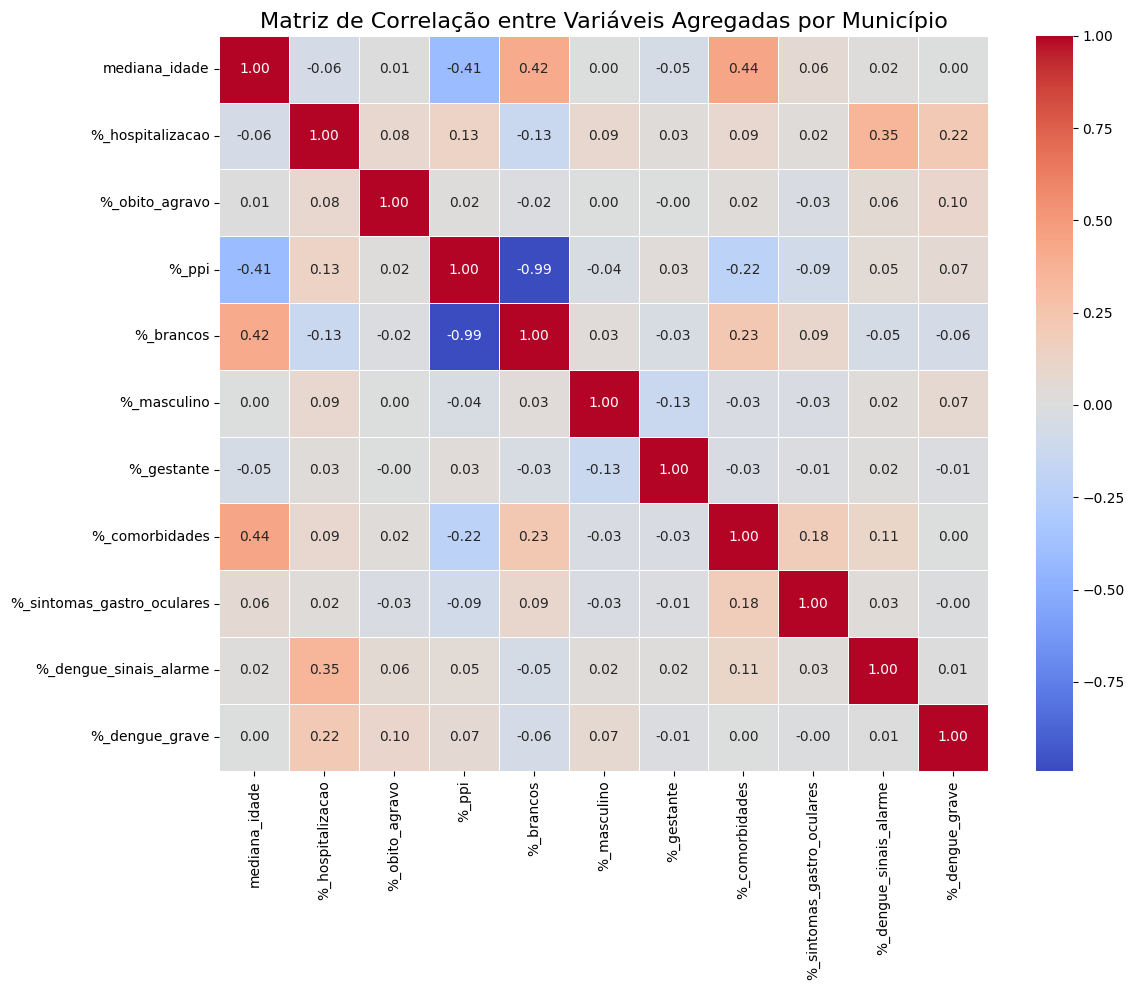

In [8]:
df_corr = df_agg.drop(columns=["municipio"])
corr_matrix = df_corr.corr()

plt.style.use("default")
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Agregadas por Município", fontsize=16)
plt.tight_layout()
plt.savefig(f"{CHARTS_PATH}corr_matrix.svg", format='svg', bbox_inches='tight')
plt.show()

Removendo colunas que não serão utilizadas na clusterização. A variável %_brancos é retirada por conta da alta correlação com a variável %_ppi.

In [9]:
df_final = df_agg.drop(columns=["%_brancos", "municipio"])
df_final.head()

,mediana_idade,%_hospitalizacao,%_obito_agravo,%_ppi,%_masculino,%_gestante,%_comorbidades,%_sintomas_gastro_oculares,%_dengue_sinais_alarme,%_dengue_grave
0,29.0,0.178862,0.000000,0.597561,0.487805,0.024390,0.052846,0.520325,0.000000,0.0
1,38.0,0.069767,0.011628,0.569767,0.406977,0.011628,0.069767,0.534884,0.023256,0.0
2,31.0,0.000000,0.000000,0.285714,0.285714,0.000000,0.142857,0.571429,0.000000,0.0
3,40.0,0.158940,0.000000,0.761589,0.417219,0.033113,0.132450,0.708609,0.059603,0.0
4,45.0,0.062500,0.000000,0.625000,0.500000,0.020833,0.125000,0.645833,0.000000,0.0


### Normalização

Normalização Z-score para evitar que algumas features, como a mediana da idade, se sobressaiam na clusterização.

In [10]:
scaler = StandardScaler()
features_norm = scaler.fit_transform(df_final)

### Escolha do K do KMeans

#### Inércia

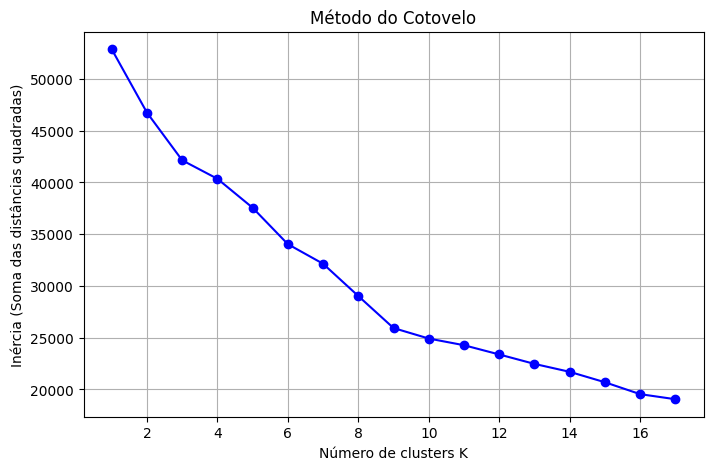

In [11]:
inertia = []
K_range = range(1, 18)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(features_norm)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, color="blue", marker="o")
plt.xlabel('Número de clusters K')
plt.ylabel('Inércia (Soma das distâncias quadradas)')
plt.title('Método do Cotovelo')
plt.style.use("default")
plt.grid(True) 
plt.savefig(f"{CHARTS_PATH}kmeans_elbow_method.svg", format='svg', bbox_inches='tight')
plt.show()

#### Coeficiente de silhueta v1

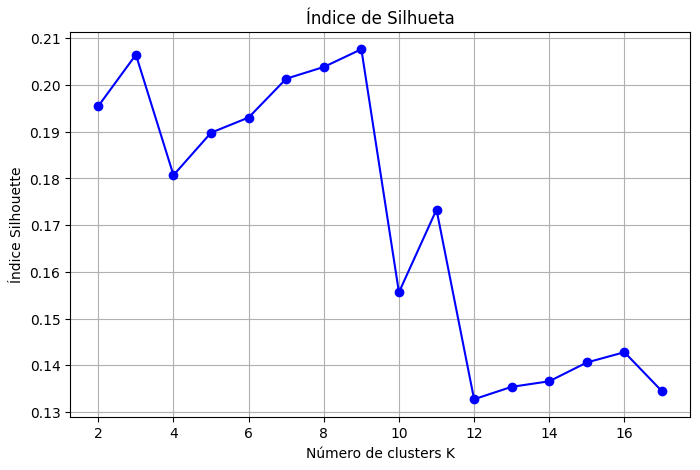

In [12]:
silhouette_scores = []
K_range = range(2, 18)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(features_norm)
    score = silhouette_score(features_norm, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, color="blue", marker="o")
plt.xlabel('Número de clusters K')
plt.ylabel('Índice Silhouette')
plt.title('Índice de Silhueta')
plt.grid(True)
plt.savefig(f"{CHARTS_PATH}kmeans_silhouette_score.svg", format='svg', bbox_inches='tight')
plt.show()

#### Coeficiente de silhueta v2

For n_clusters = 2 The average silhouette_score is : 0.19548763702858676
For n_clusters = 3 The average silhouette_score is : 0.20649720569156862
For n_clusters = 4 The average silhouette_score is : 0.180693016249495
For n_clusters = 5 The average silhouette_score is : 0.18978828576603737
For n_clusters = 6 The average silhouette_score is : 0.19303916534004625
For n_clusters = 7 The average silhouette_score is : 0.2013476692531093
For n_clusters = 8 The average silhouette_score is : 0.20385827677817003
For n_clusters = 9 The average silhouette_score is : 0.20766217955995722
For n_clusters = 10 The average silhouette_score is : 0.15560172248998563
For n_clusters = 11 The average silhouette_score is : 0.17332106014359094
For n_clusters = 12 The average silhouette_score is : 0.13271578346266627


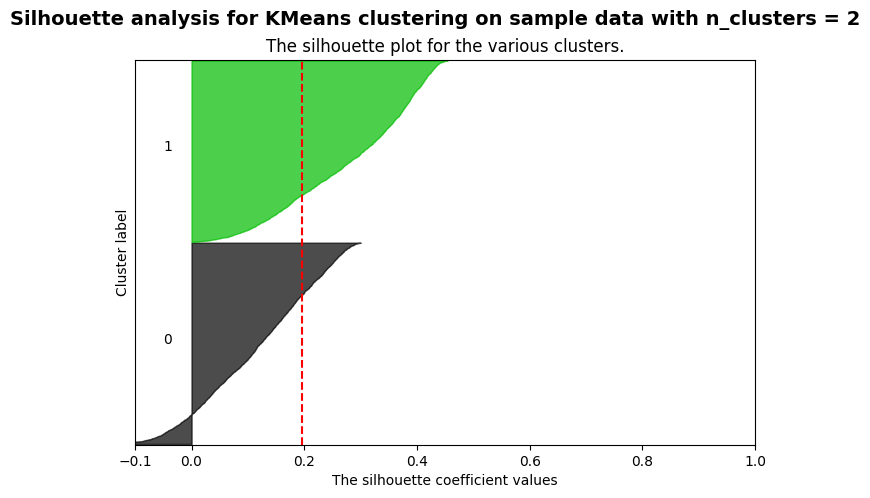

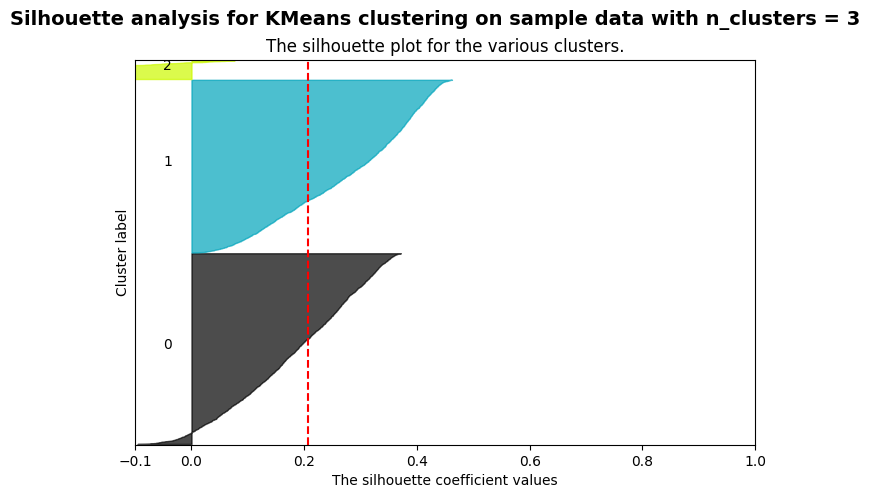

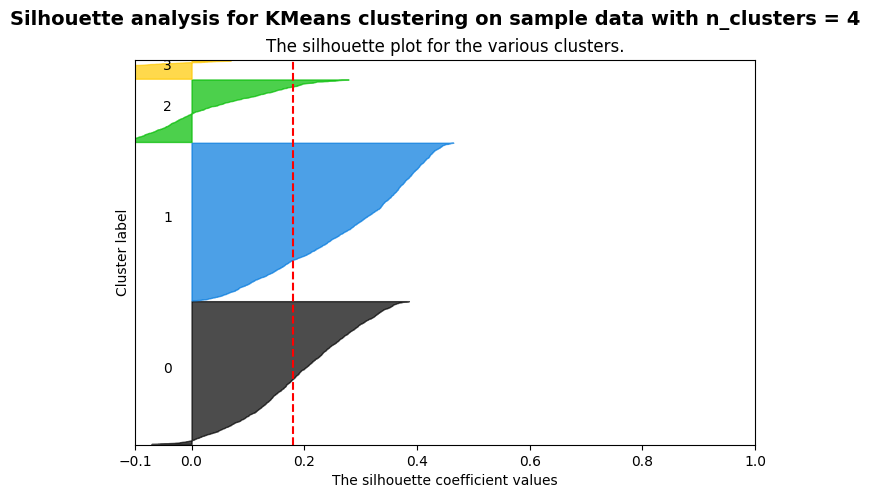

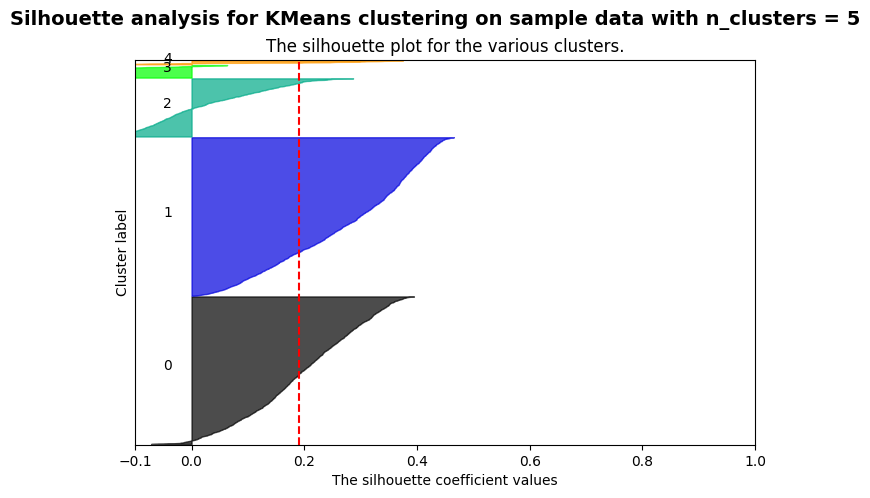

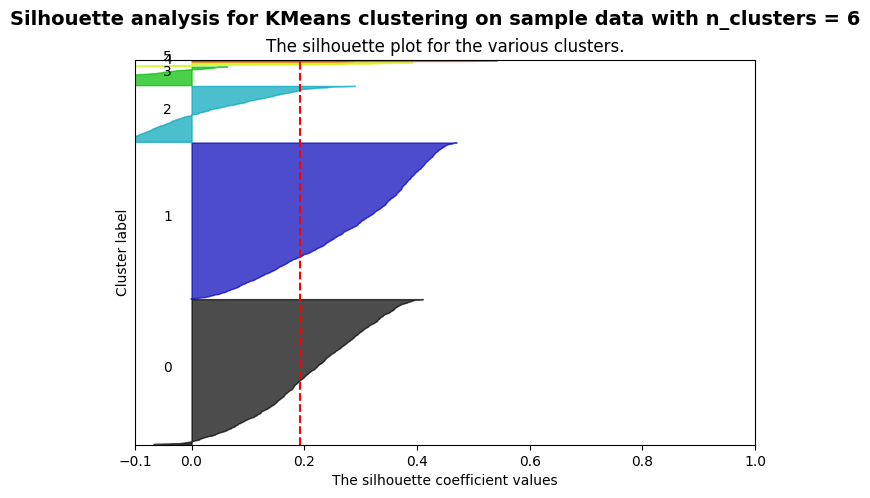

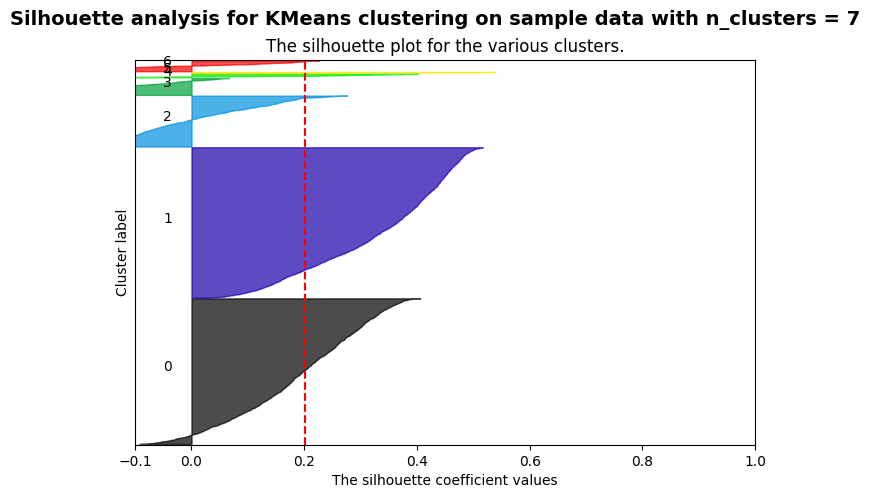

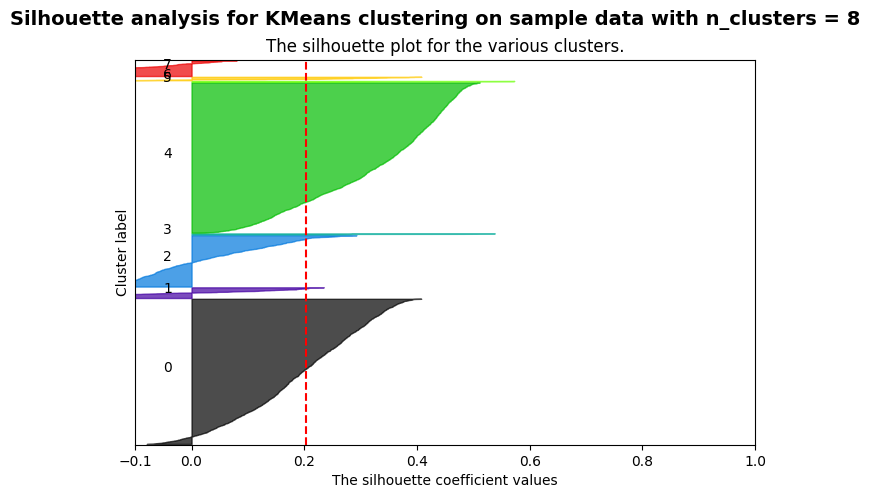

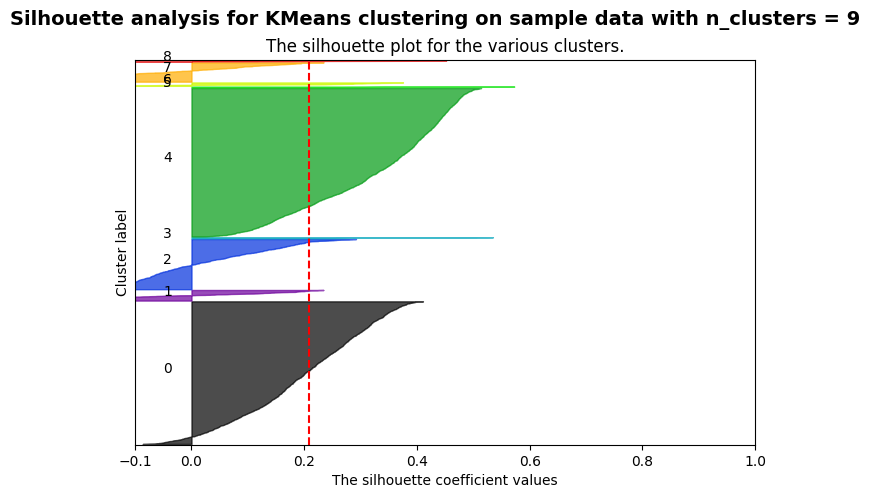

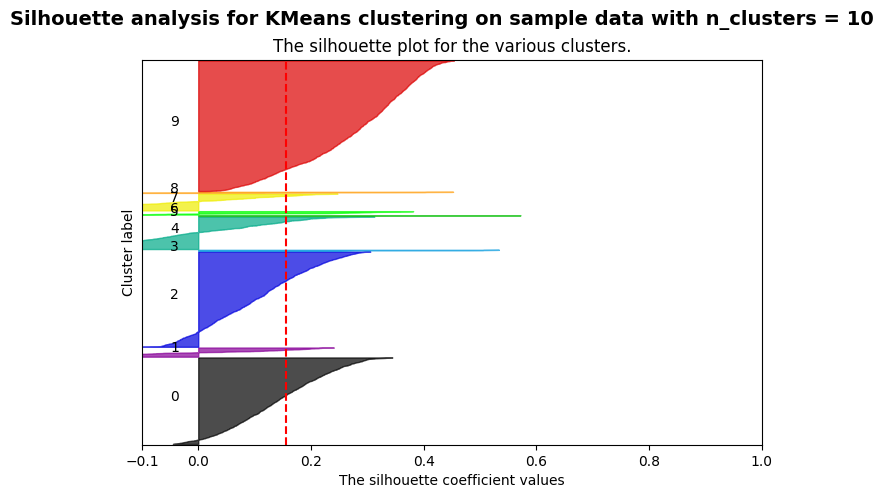

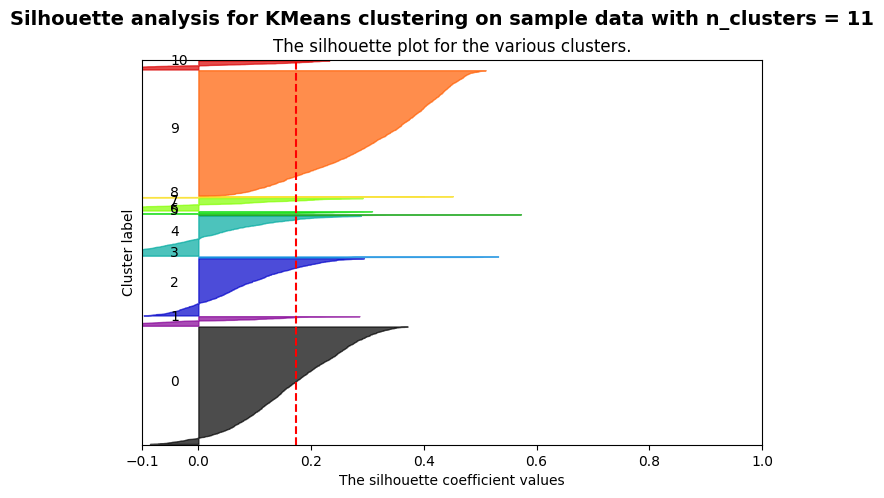

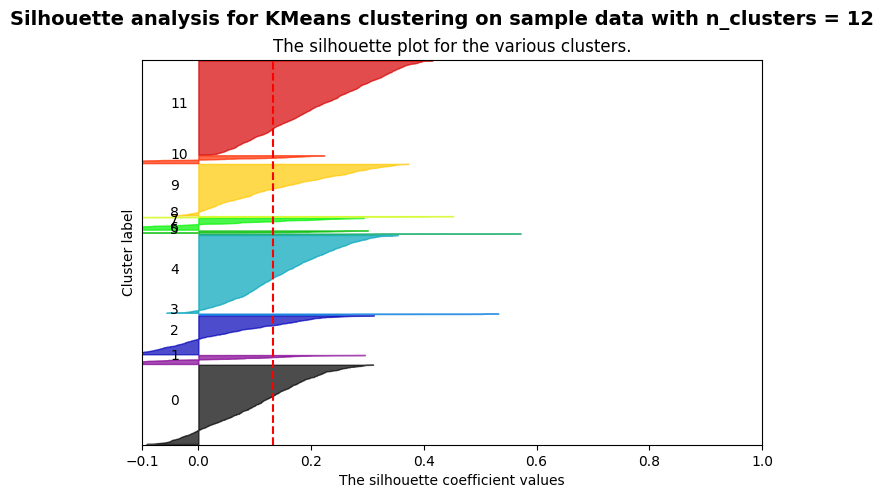

In [13]:
# Trecho adaptado de 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(8, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(features_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(features_norm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features_norm, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

## Clusterização

### KMeans (melhor resultado)

O melhor valor de K obtido de acordo com a inércia e silhueta para *random_state=1* foi **K=9**.

In [14]:
kmeans = KMeans(n_clusters=9, random_state=1)
clusters = kmeans.fit_predict(features_norm)

#### Visualização

Utilização de PCA para tentativa de visualização dos clusters em 2 dimensões.

In [15]:
pca_2d = PCA(n_components=2)
features_pca_2d = pca_2d.fit_transform(features_norm)

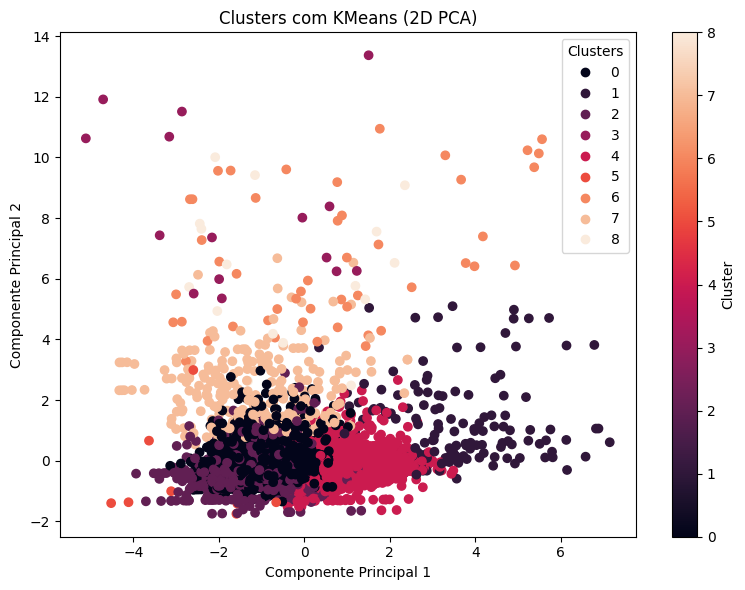

In [16]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=clusters, cmap='rocket')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("Clusters com KMeans (2D PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [17]:
# Adicionando coluna de clusters no dataframe
df_clustered = df_agg.copy()
df_clustered["cluster"] = clusters
df_clustered.head()

,municipio,mediana_idade,%_hospitalizacao,%_obito_agravo,%_ppi,%_brancos,%_masculino,%_gestante,%_comorbidades,%_sintomas_gastro_oculares,%_dengue_sinais_alarme,%_dengue_grave,cluster
0,110001.0,29.0,0.178862,0.000000,0.597561,0.394309,0.487805,0.024390,0.052846,0.520325,0.000000,0.0,2
1,110002.0,38.0,0.069767,0.011628,0.569767,0.267442,0.406977,0.011628,0.069767,0.534884,0.023256,0.0,2
2,110003.0,31.0,0.000000,0.000000,0.285714,0.714286,0.285714,0.000000,0.142857,0.571429,0.000000,0.0,4
3,110004.0,40.0,0.158940,0.000000,0.761589,0.225166,0.417219,0.033113,0.132450,0.708609,0.059603,0.0,0
4,110005.0,45.0,0.062500,0.000000,0.625000,0.312500,0.500000,0.020833,0.125000,0.645833,0.000000,0.0,4


#### Análises

##### Mapa de calor da porcentagem de características presentes por cluster

In [18]:
df_stats = df_clustered.drop(columns=['municipio', 'mediana_idade'])
stats_por_cluster = df_stats.groupby('cluster').mean()
stats_por_cluster = stats_por_cluster * 100

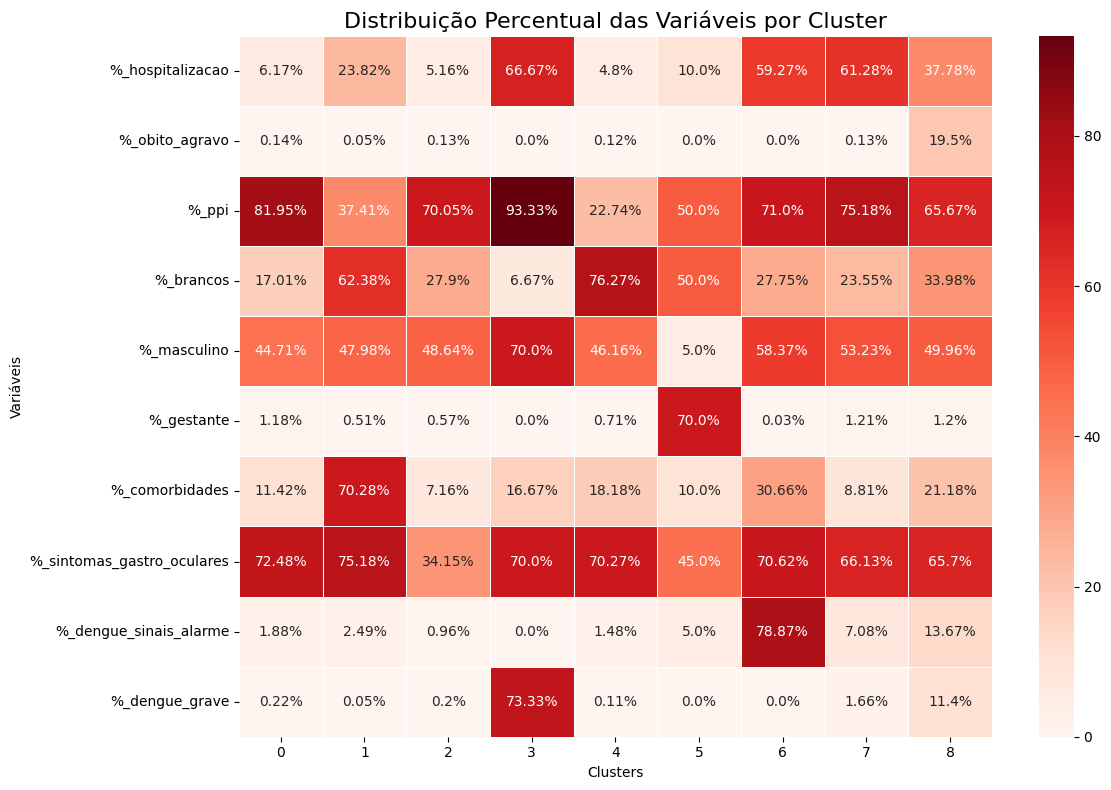

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(stats_por_cluster.T, annot=stats_por_cluster.T.round(2).astype(str) + '%', fmt="", cmap='Reds', linewidths=0.5)
plt.title("Distribuição Percentual das Variáveis por Cluster", fontsize=16)
plt.xlabel("Clusters")
plt.ylabel("Variáveis")
plt.tight_layout()
plt.savefig(f"{CHARTS_PATH}clusters_features_distribution_heatmap.svg", format='svg', bbox_inches='tight')
plt.show()

##### Gráfico de barra da porcentagem de características presentes por cluster

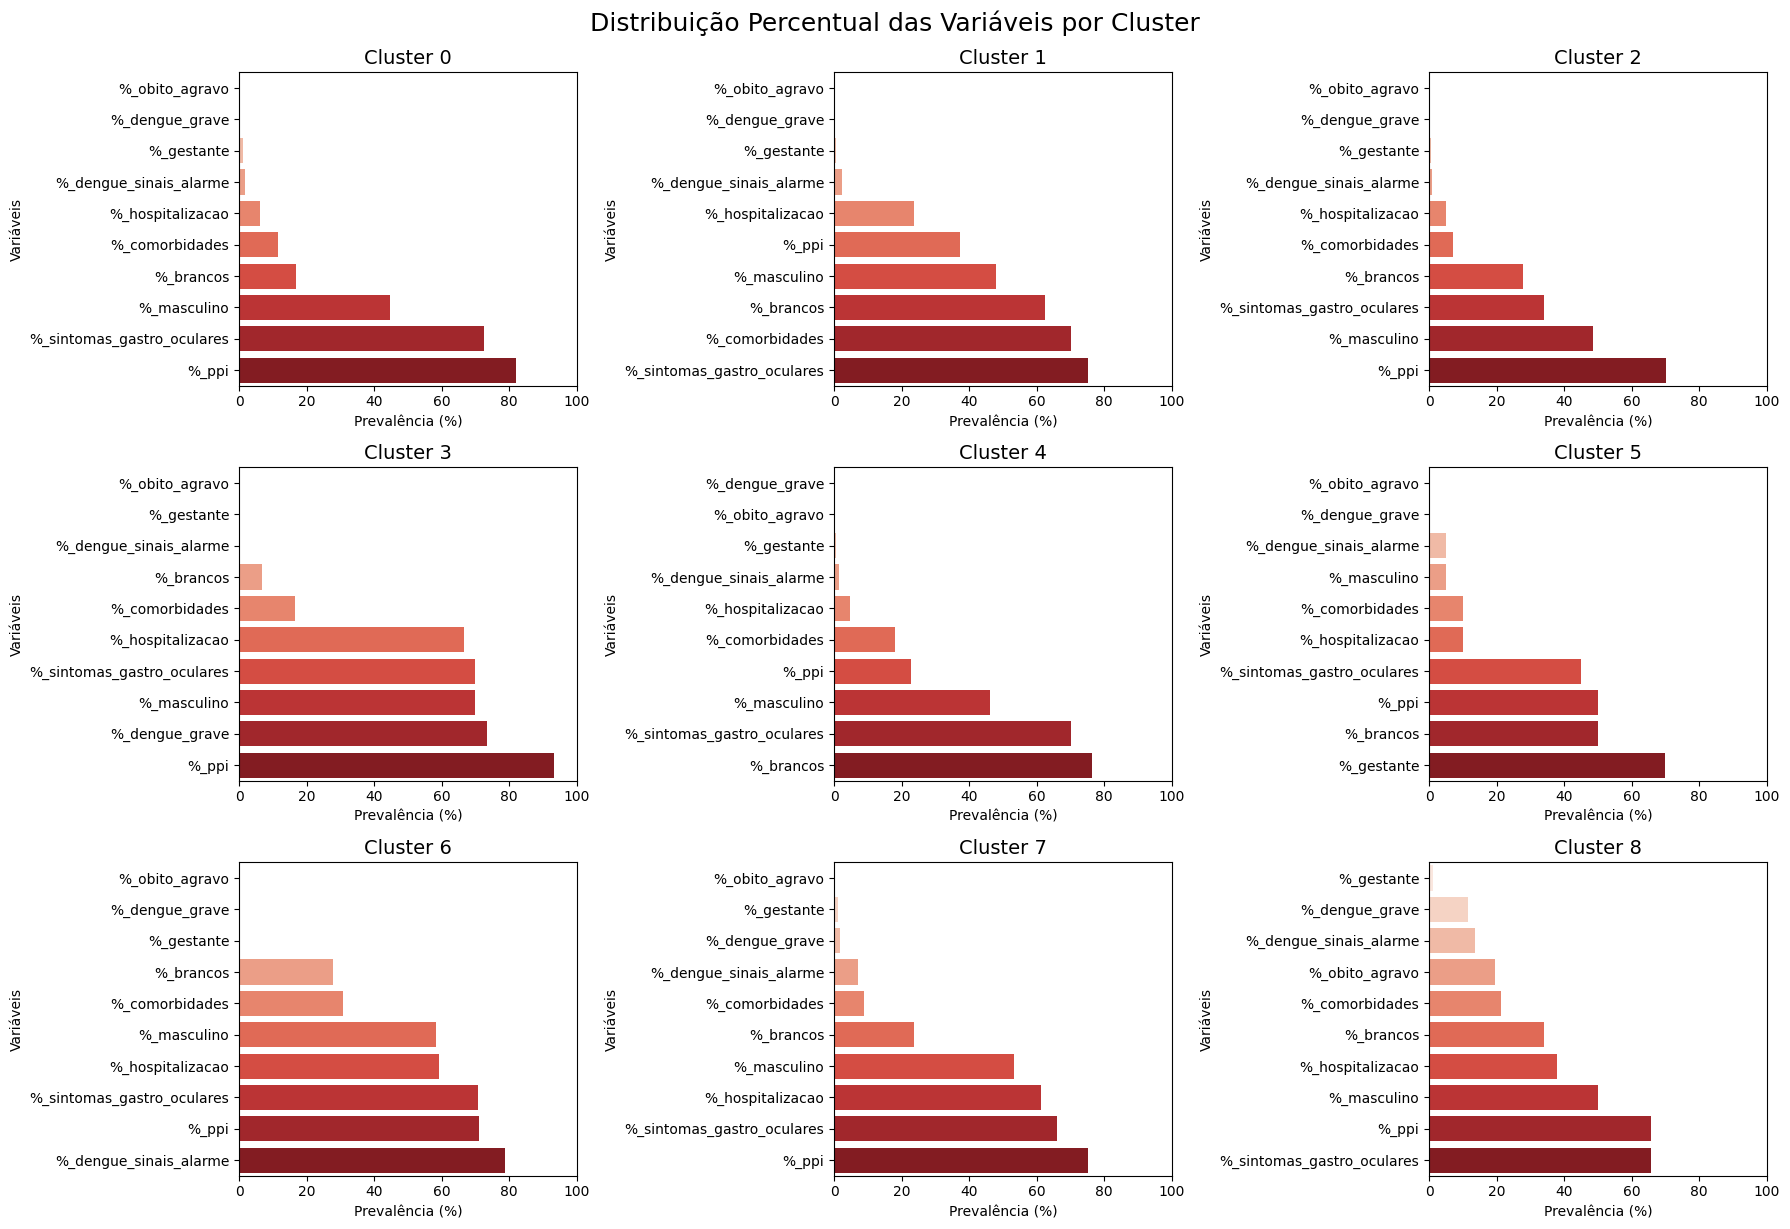

In [20]:

n_clusters = stats_por_cluster.T.shape[1]  # número de clusters

plt.style.use("default")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, ax in enumerate(axes[:n_clusters]):
    cluster_data = stats_por_cluster.T.iloc[:, i].sort_values()
    sns.barplot(x=cluster_data.values, y=cluster_data.index, ax=ax, palette="Reds", hue=cluster_data.index)
    ax.set_title(f"Cluster {i}", fontsize=14)
    ax.set_xlabel("Prevalência (%)")
    ax.set_ylabel("Variáveis")
    ax.set_xlim(0, 100)
    # ax.grid(axis='x', alpha=0.7, zorder=0)

# Remove axes extras se o número for ímpar
for j in range(n_clusters, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.suptitle("Distribuição Percentual das Variáveis por Cluster", fontsize=18, y=1.02)
plt.savefig(f"{CHARTS_PATH}clusters_features_distribution_barplot.svg", format='svg', bbox_inches='tight')
plt.show()

##### Gráfico de barras da média da mediana de idades por cluster

/tmp/ipykernel_60613/772613446.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_median_age.index, y=values, palette=colors, zorder=3)


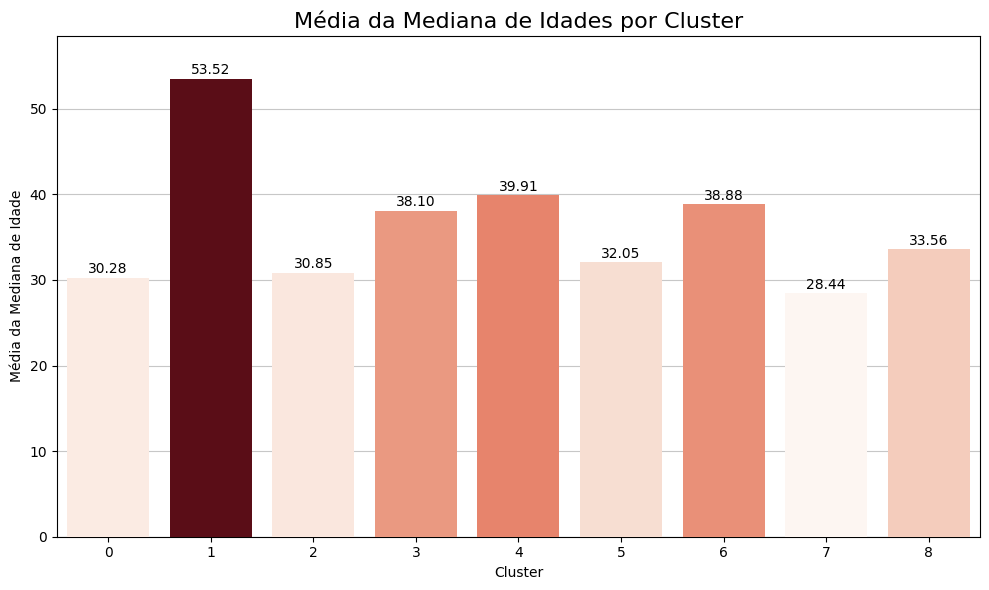

In [21]:
mean_median_age = df_clustered.groupby('cluster')['mediana_idade'].mean()
values = mean_median_age.values

plt.style.use("default")

# Normaliza os valores para 0-1 para aplicar no colormap
norm = (values - values.min()) / (values.max() - values.min())
colors = [cm.Reds(v) for v in norm]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_median_age.index, y=values, palette=colors, zorder=3)

plt.title("Média da Mediana de Idades por Cluster", fontsize=16)
plt.xlabel("Cluster")
plt.ylabel("Média da Mediana de Idade")
plt.xticks(mean_median_age.index)
plt.ylim(0, values.max() + 5)
plt.grid(axis='y', alpha=0.7, zorder=0)

# Mostra os valores acima das barras
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig(f"{CHARTS_PATH}mean_median_age_by_cluster.svg", format='svg', bbox_inches='tight')
plt.show()

##### Mapa de calor da prevalência percentual por estado em cada cluster

Aqui foi utilizado os dois primeiros dígitos do código do município, que correspondem ao código do estado.<br>

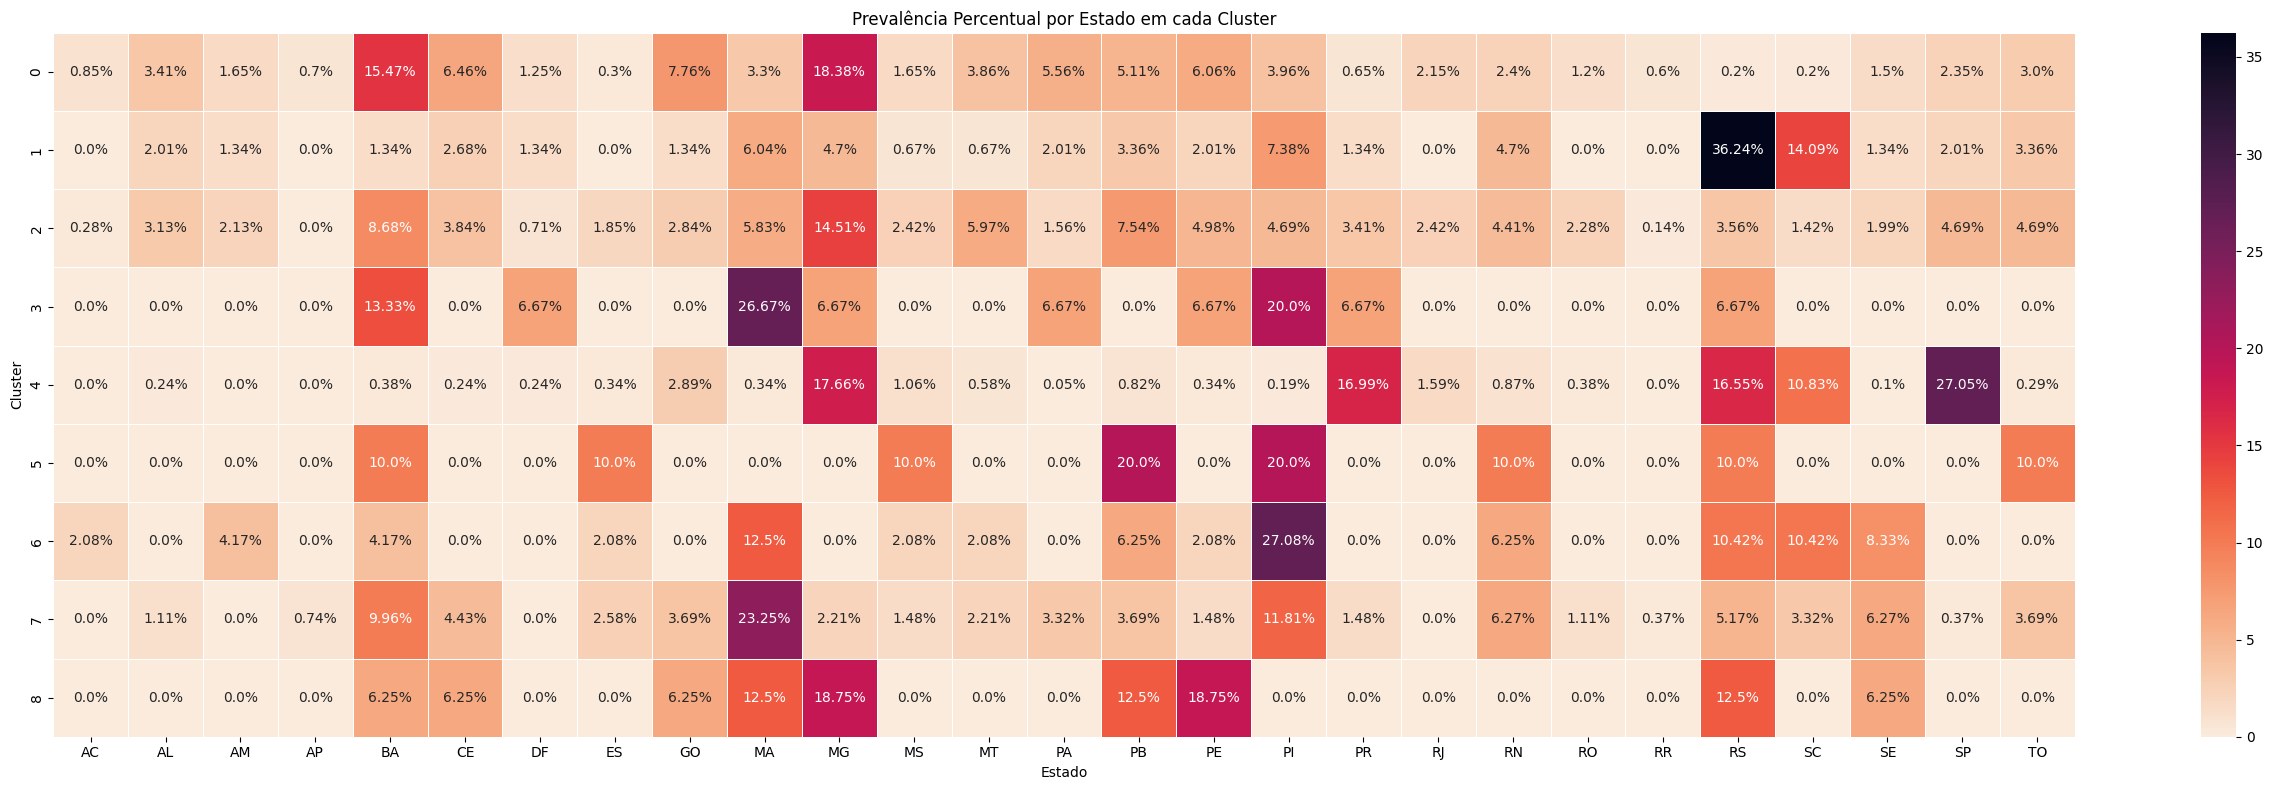

In [22]:
# Converte para string e extrai os 2 primeiros dígitos como código do estado
df_clustered['codigo_uf'] = df_clustered['municipio'].astype(int).astype(str).str[:2]
df_clustered['codigo_uf'] = df_clustered['codigo_uf'].astype(int)

codigo_uf_para_nome = {
    11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
    21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 
    28: 'SE', 29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 
    42: 'SC', 43: 'RS', 50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
}

df_clustered['estado'] = df_clustered['codigo_uf'].map(codigo_uf_para_nome)
contagem_estado = df_clustered.groupby(['cluster', 'estado']).size().unstack(fill_value=0)
percentual_estado = contagem_estado.div(contagem_estado.sum(axis=1), axis=0) * 100
plt.figure(figsize=(26, 8))
sns.heatmap(percentual_estado, annot=percentual_estado.round(2).astype(str) + '%', fmt='', cmap='rocket_r', linewidths=0.5)
plt.title('Prevalência Percentual por Estado em cada Cluster')
plt.xlabel('Estado')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig(f"{CHARTS_PATH}mun_distribution_by_state_heatmap.svg", format='svg', bbox_inches='tight')
plt.show()


##### Visualização da prevalência percentual de estados por cluster em mapa com geopandas

In [23]:
# GeoJSON com os estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

brasil = brasil.rename(columns={"name": "estado"})
brasil["estado"] = brasil["estado"].str.upper()

In [24]:
# Reconstruindo a tabela
df_long = percentual_estado.reset_index().melt(id_vars='cluster', var_name='estado', value_name='prevalencia')

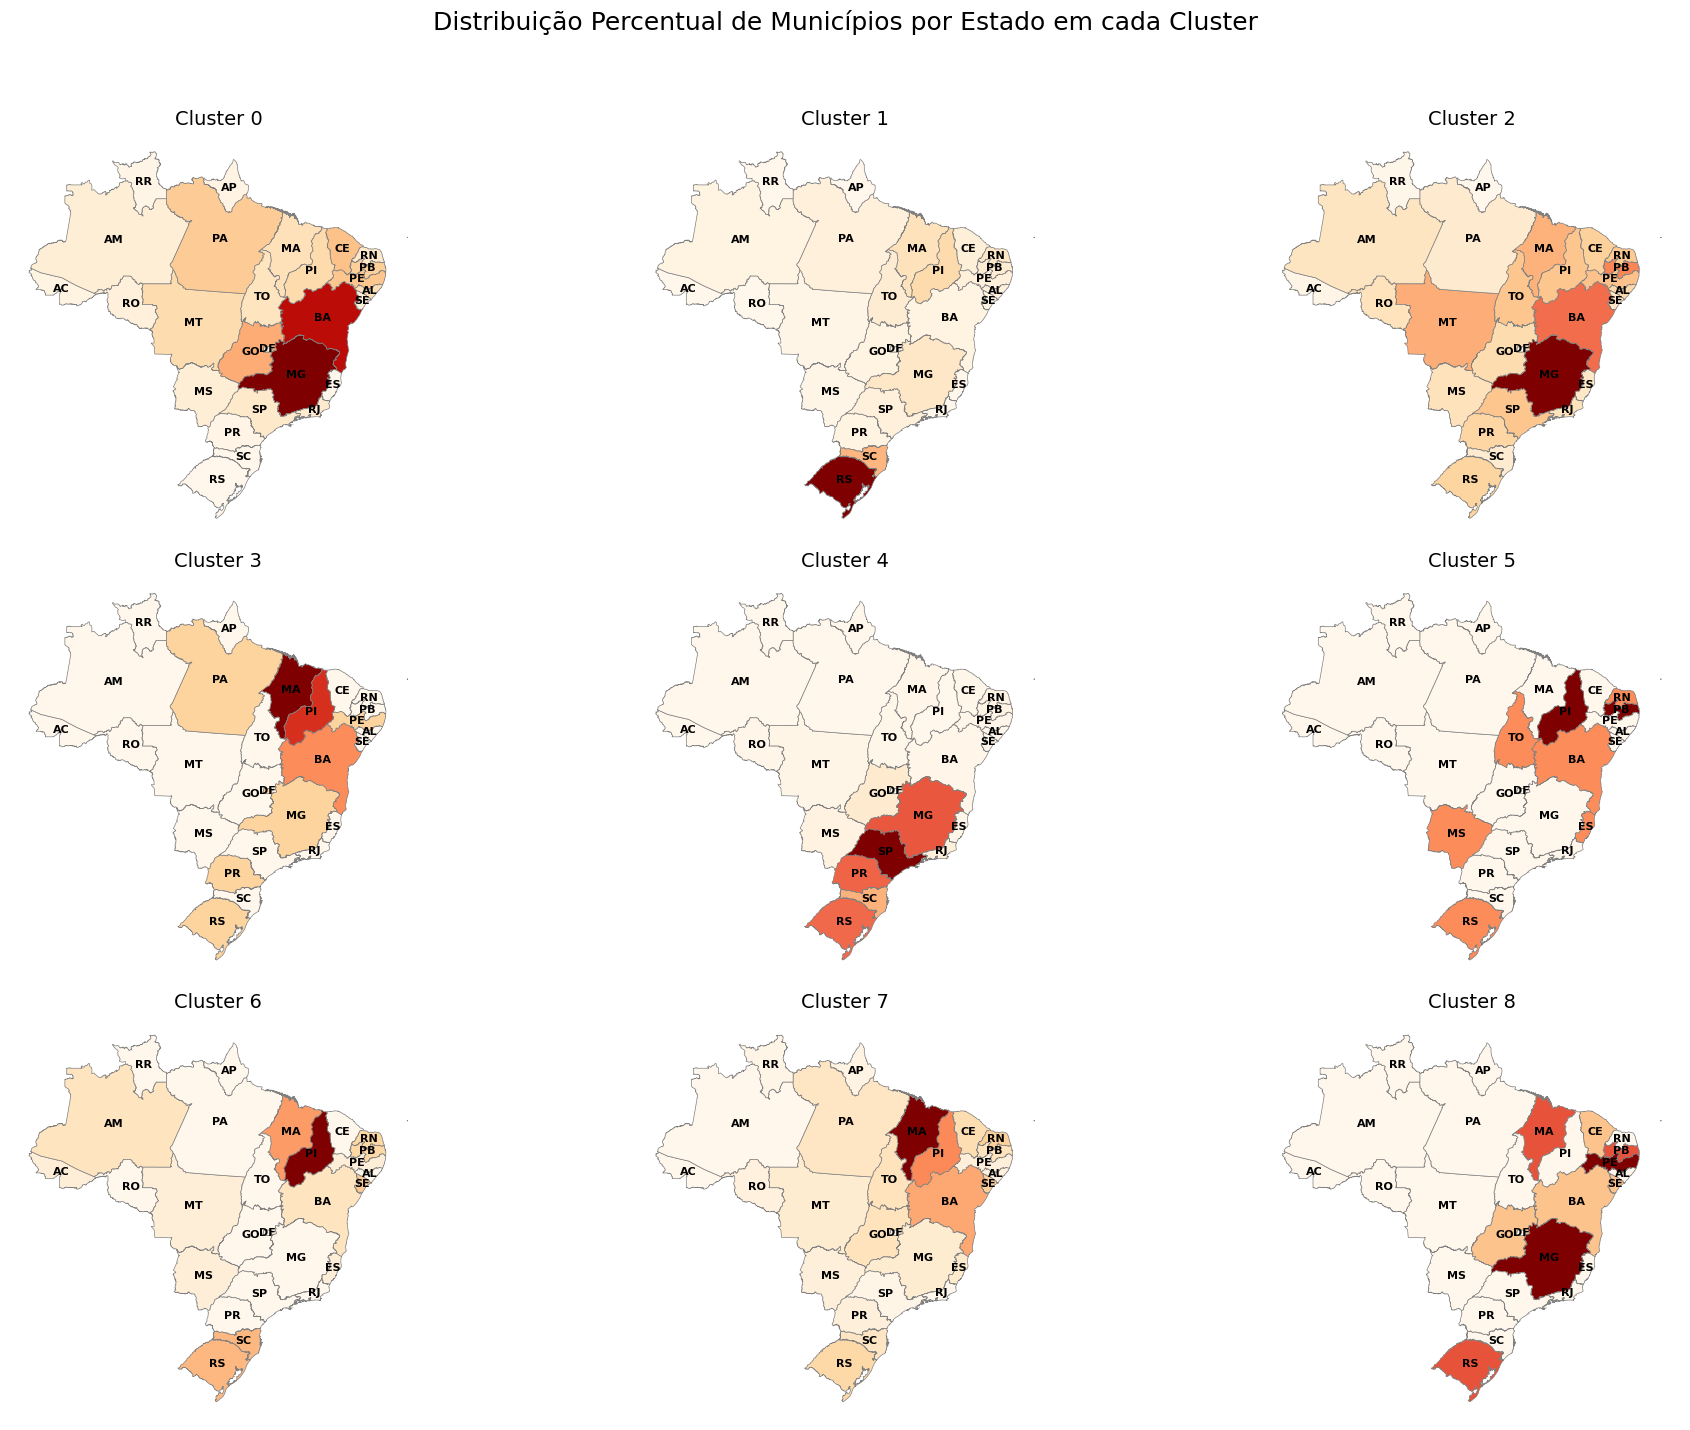

In [25]:
cltrs = sorted(df_long['cluster'].unique())
n = len(cltrs)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, cluster_id in enumerate(cltrs):
    dados_cluster = df_long[df_long['cluster'] == cluster_id]

    # Join com o mapa
    mapa = brasil.merge(dados_cluster, left_on='sigla', right_on="estado", how="left")

    # Plot
    mapa.plot(
        column="prevalencia",
        cmap="OrRd",
        linewidth=0.5,
        ax=axes[i],
        edgecolor='0.5',
        legend=False,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
    )

    # Adicionar sigla dos estados no centroide
    for idx, row in mapa.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            x, y = row['geometry'].centroid.coords[0]
        else:  # MultiPolygon: usa o centroide geral
            x, y = row['geometry'].centroid.coords[0]
        axes[i].annotate(
            row['sigla'],
            xy=(x, y),
            ha='center',
            va='center',
            fontsize=8,
            color='black',
            weight='bold'
        )

    axes[i].set_title(f"Cluster {cluster_id}", fontsize=14)
    axes[i].axis('off')

# Remover subplots extras
for j in range(i + 1, 9):
    fig.delaxes(axes[j])

plt.suptitle("Distribuição Percentual de Municípios por Estado em cada Cluster", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"{CHARTS_PATH}mun_distribution_by_state_map.svg", format='svg', bbox_inches='tight')
plt.show()

Salva figuras individuais para cada subplot.

In [26]:
output_path = f"{CHARTS_PATH}clusters_combined_features_and_maps"
os.makedirs(output_path, exist_ok=True)

# sns.set_theme(style="white")
n_clusters = stats_por_cluster.T.shape[1]
cltrs = sorted(df_long['cluster'].unique())

for i in range(n_clusters):
    # Dados das features
    cluster_data = stats_por_cluster.T.iloc[:, i].sort_values()

    # Dados do mapa
    cluster_id = cltrs[i]
    dados_cluster = df_long[df_long['cluster'] == cluster_id]
    mapa = brasil.merge(dados_cluster, left_on='sigla', right_on="estado", how="left")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 linha, 2 colunas

    # ----------- Subplot 1: Distribuição de features
    sns.barplot(
        x=cluster_data.values,
        y=cluster_data.index,
        ax=axes[0],
        hue=cluster_data.index,
        palette="Reds",
        dodge=False,
    )
    axes[0].set_title("Distribuição das variáveis", fontsize=14)
    axes[0].set_xlabel("Prevalência (%)")
    axes[0].set_ylabel("Variáveis")
    axes[0].set_xlim(0, 100)

    # ----------- Subplot 2: Mapa de prevalência
    mapa.plot(
        column="prevalencia",
        cmap="OrRd",
        linewidth=0.5,
        ax=axes[1],
        edgecolor='0.5',
        legend=False,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
    )
    for _, row in mapa.iterrows():
        if row['geometry'].is_empty:
            continue
        try:
            centroid = row['geometry'].centroid
            x, y = centroid.x, centroid.y
            axes[1].annotate(
                row['sigla'],
                xy=(x, y),
                ha='center',
                va='center',
                fontsize=8,
                color='black',
                weight='bold',
            )
        except:
            continue

    axes[1].set_title("Distribuição geográfica", fontsize=14)
    axes[1].axis('off')

    fig.suptitle(f"Cluster {cluster_id}", fontsize=16, weight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Espaço pro título geral
    combined_path = f"{output_path}/cluster_{cluster_id}.svg"
    plt.savefig(combined_path, format='svg', bbox_inches='tight')
    plt.close(fig)

### Agrupamento Espectral (resultado insatisfatório)

Utilizando *eigengap* para definir um bom valor de K, o valor mais expressivo no gráfico foi **K=2**. Com esse valor, os clusters formados não demonstraram resultados interessantes para nossa análise.

#### Escolha do K

Calculando eigengap

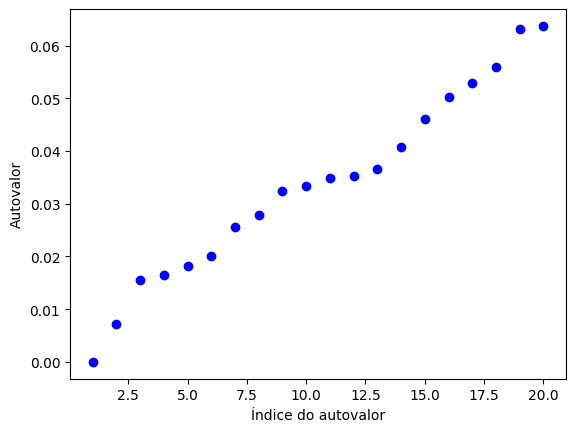

In [27]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA

# Construindo a matriz de adjacências do grafo de vizinhos mais próximos.
G = kneighbors_graph(features_norm, n_neighbors = 10, include_self = True)
A = 0.5 * (G + G.T)

# Construindo a Laplaciana Normalizada
L = csgraph.laplacian(A, normed = True).todense()

# Obtendo os autovalores da Laplaciana Normalizada
values, _ = LA.eigh(L)

# Plotando os valores dos gaps
plt.style.use("default")
plt.scatter([i for i in range(1, 21)], values[:20], color="blue")
plt.xlabel('Índice do autovalor')
plt.ylabel('Autovalor');

#### Cluserização

In [28]:
n_clusters = 2

spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels_spectral = spectral.fit_predict(features_norm)

df_clustered['cluster_spectral'] = labels_spectral

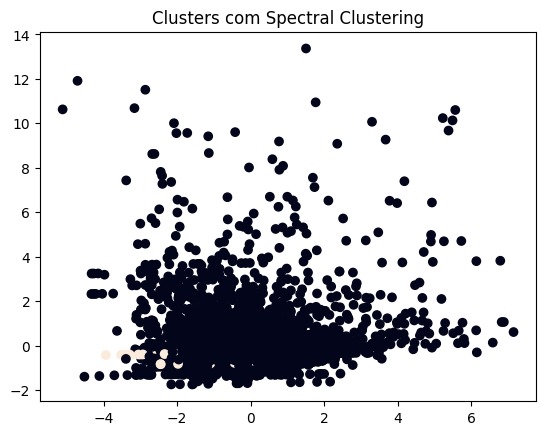

In [29]:
plt.scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=labels_spectral, cmap='rocket')
plt.title("Clusters com Spectral Clustering")
plt.show()

In [30]:
df_clustered.head()

,municipio,mediana_idade,%_hospitalizacao,%_obito_agravo,%_ppi,%_brancos,%_masculino,%_gestante,%_comorbidades,%_sintomas_gastro_oculares,%_dengue_sinais_alarme,%_dengue_grave,cluster,codigo_uf,estado,cluster_spectral
0,110001.0,29.0,0.178862,0.000000,0.597561,0.394309,0.487805,0.024390,0.052846,0.520325,0.000000,0.0,2,11,RO,0
1,110002.0,38.0,0.069767,0.011628,0.569767,0.267442,0.406977,0.011628,0.069767,0.534884,0.023256,0.0,2,11,RO,0
2,110003.0,31.0,0.000000,0.000000,0.285714,0.714286,0.285714,0.000000,0.142857,0.571429,0.000000,0.0,4,11,RO,0
3,110004.0,40.0,0.158940,0.000000,0.761589,0.225166,0.417219,0.033113,0.132450,0.708609,0.059603,0.0,0,11,RO,0
4,110005.0,45.0,0.062500,0.000000,0.625000,0.312500,0.500000,0.020833,0.125000,0.645833,0.000000,0.0,4,11,RO,0


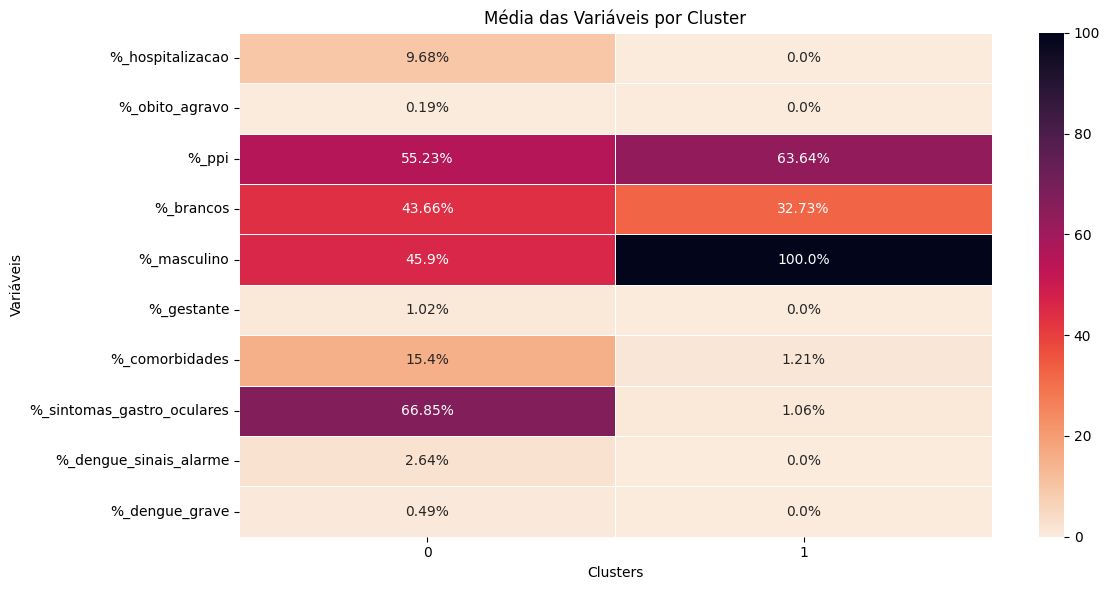

In [31]:
df_stats_spectral = df_clustered.drop(columns=['municipio', 'mediana_idade', "codigo_uf", "estado", "cluster"])
stats_por_cluster_spectral = df_stats_spectral.groupby('cluster_spectral').mean()

stats_por_cluster_spectral = stats_por_cluster_spectral * 100
plt.figure(figsize=(12, 6))
sns.heatmap(stats_por_cluster_spectral.T, annot=stats_por_cluster_spectral.T.round(2).astype(str) + '%', fmt="", cmap='rocket_r', linewidths=0.5)
plt.title("Média das Variáveis por Cluster")
plt.xlabel("Clusters")
plt.ylabel("Variáveis")
plt.tight_layout()
plt.show()

### DBSCAN (resultado insatisfatório)

O valor de min_samples foi escolhido com base na dimensionalidade dos dados. Já o epsilon foi calculado com o k-distance plot. Entretanto, o algoritmo foi capaz de formar apenas um cluster. Muito se deve ao fato de os dados estarem densamente aglomerados, situação não muito favorável para este caso.

#### Escolha do eps

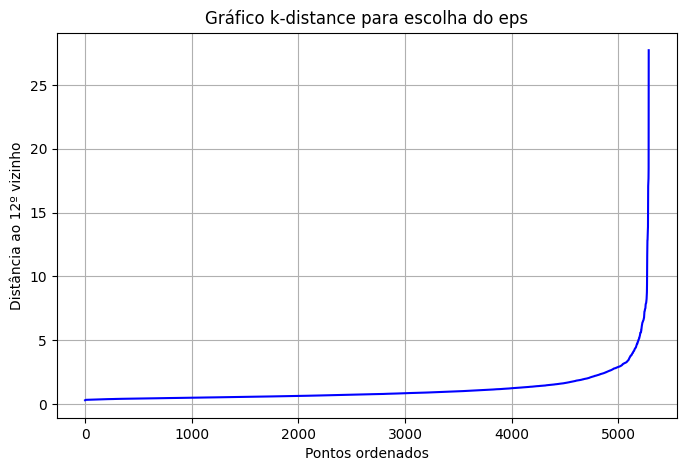

In [32]:
# k = D + 1
k = 12  # igual ao min_samples 
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(features_norm)
distances, indices = neighbors_fit.kneighbors(features_norm)

distances = np.sort(distances[:, -1])  # distância até o 10º vizinho

plt.figure(figsize=(8, 5))
plt.plot(distances, color="blue")
plt.title("Gráfico k-distance para escolha do eps")
plt.xlabel("Pontos ordenados")
plt.ylabel(f"Distância ao {k}º vizinho")
plt.grid(True)
plt.show()

#### Clusterização

In [33]:
dbscan = DBSCAN(eps=4, min_samples=k)
labels = dbscan.fit_predict(features_norm)

df_clustered['cluster_dbscan'] = labels

Text(0.5, 1.0, 'Distribuição dos Clusters pelo DBSCAN')

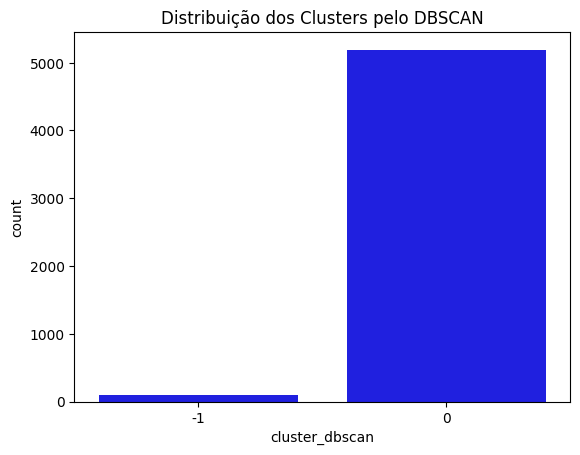

In [34]:
sns.countplot(x='cluster_dbscan', data=df_clustered, color="blue")
plt.title("Distribuição dos Clusters pelo DBSCAN")